In the previous chapter on multilevel modeling, our adaptive priors allowed us to use data about one subgroup of the data to learn about other groups. However, that knowledge transfer was limited to parameters of the same type. Like in the chimpanzee example, all of our $\alpha_j$'s had one prior parametrized by $\bar{\alpha}$ and $\sigma_\alpha$, and all the $\gamma_j$'s were parametrized by a $\sigma_\gamma$. Learning something about $\alpha_1$ helped us learn a bit about $\alpha_2$, but nothing about $\gamma_2$. In real life, sometimes there are correlations between different types of variables that allow us to learn something about multiple types at the same time and squeeze more information from our data.

In [2]:
import sys, warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Path, PathPatch
import seaborn as sns
import scipy.stats as stats
from scipy import interpolate
import torch
tt =  torch.tensor
import pyro
from pyro import poutine
from pyro.distributions import (
    MultivariateNormal, Normal, LKJCorrCholesky, LKJCholesky, Exponential, Bernoulli, Poisson, HalfNormal
)
from pyro.infer import Predictive
from pyro.ops.stats import waic, hpdi
import arviz as az
import xarray as xr
import networkx as nx

from utils import traceplot, train_nuts

torch.multiprocessing.set_sharing_strategy("file_system")
pyro.enable_validation()

In [3]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Sep 24 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

xarray    : 2024.5.0
numpy     : 1.26.4
sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]
arviz     : 0.17.1
matplotlib: 3.9.0
seaborn   : 0.12.2
pandas    : 2.2.2
torch     : 2.3.0
scipy     : 1.12.0
networkx  : 3.1
pyro      : 1.9.1

Watermark: 2.4.3



In [47]:
def unnest_samples(s, max_depth=1):
    """Unnests samples from multivariate distributions
    
    The general index structure of a sample tensor is
    [[chains,] samples [,idx1, idx2, ...]]. Sometimes the distribution is univariate
    and there are no additional indices. So we will always unnest from the right, but
    only if the tensor has rank of 3 or more (2 in the case of no grouping by chains).
    """
    def _unnest_samples(s):
        _s = dict()
        for k in s:
            assert s[k].dim() > 0
            if s[k].dim() == 1:
                _s[k] = s[k]
            elif s[k].dim() == 2:
                for i in range(s[k].shape[1]):
                    _s[f"{k}[{i}]"] = s[k][:,i]
            else:
                for i in range(s[k].shape[1]):
                    _s[f"{k}[{i}]"] = s[k][:,i,...]
        return _s
    
    for _ in range(max_depth):
        s = _unnest_samples(s)
        if all([v.dim() == 1 for v in s.values()]):
            break
    return s


### Code 14.1 - 14.17
For example, if we consider our cafe-visiting robot example from before, perhaps as it goes from cafe to cafe, it also orders multiple drinks; one in the morning, and one in the afternoon. As it turns out, popular cafes are very busy in the morning (and have long wait times), and have much lower waits during the afternoon. Unpopular cafes have low wait times in both the morning and afternoon. So if the robot visits a cafe in the morning and observes that it takes a while to get it's order, it can already make a good guess that the wait in the afternoon will be significantly less. In this example, the wait times and time of day are correlated.

We can do a simulation to demonstrate this relationship and how it can be harnessed in our multilevel models. First, we will sample from a multivariate normal distribution representing the slopes and intercepts of our model for how the _average_ waiting time of the population of cafes changes according to time of day.

In [48]:
a = 3.5 # average morning wait time
b = -1 # avg. difference between afternoon/morning waits
sigma_a = 1.
sigma_b = 0.5
rho = -0.7 # correlation between intercepts and slopes

Mu = tt([a, b])
cov_ab = sigma_a*sigma_b*rho
Sigma = tt([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])

N_cafes = 20
vary_effects = MultivariateNormal(Mu, Sigma).sample([N_cafes])

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

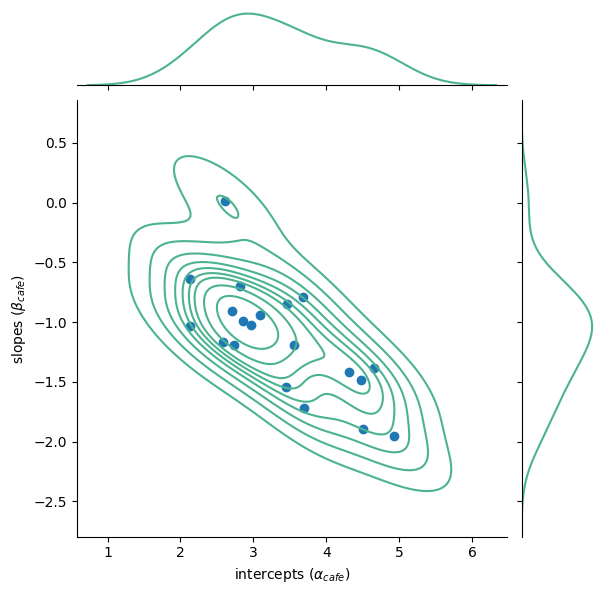

In [49]:

M = vary_effects.numpy()
d = {"x": M[:, 0], "y": M[:,1]}
df = pd.DataFrame(d)
#sns.kdeplot(data=df, x="x", y="y", cmap="viridis")
sns.jointplot(x=df["x"], y=df["y"], kind="kde", color="#4CB391")
plt.scatter(*vary_effects.T)
plt.xlabel(r"intercepts ($\alpha_{cafe}$)")
plt.ylabel(r"slopes ($\beta_{cafe}$)")
plt.show()

Then, we can take our slopes/intercepts sampled from the population, compute the average wait times, and then sample from a normal distribution centered on _that_ average.

In [50]:
N_visits = 10
afternoon = tt((N_cafes*N_visits//2)*[0, 1])
cafe_id = tt(sum([N_visits*[i] for i in range(N_cafes)], []))
a_cafe, b_cafe = vary_effects.T
mu = a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma = tt(0.5)
wait = Normal(mu, sigma).sample()
df = pd.DataFrame({"cafe": cafe_id.numpy(), "afternoon": afternoon.numpy(), "wait": wait.numpy()})
df.sample(5)

,cafe,afternoon,wait
95,9,1,1.860013
71,7,1,2.777002
30,3,0,3.065773
175,17,1,2.337892
130,13,0,2.492724


Now, we're going to build a Bayesian model of our cafe waiting time process. It has the following structure:

$$\begin{align*}
W_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha_\text{cafe[i]} + \beta_\text{cafe[i]} A_i \\
\begin{pmatrix} \alpha_\text{cafe}\\ \beta_\text{cafe} \end{pmatrix} &\sim \text{MVNormal}\left(\begin{pmatrix} \alpha\\ \beta \end{pmatrix}, \boldsymbol{S}\right) \\
\boldsymbol{S} &= \begin{pmatrix} \sigma_\alpha & 0 \\ 0 & \sigma_\beta \end{pmatrix} \boldsymbol{R} \begin{pmatrix} \sigma_\alpha & 0 \\ 0 & \sigma_\beta \end{pmatrix} \\
\alpha &\sim \text{Normal}(5, 2) \\
\beta &\sim \text{Normal}(-1, 0.5) \\
\sigma &\sim \text{Exponential}(1) \\
\sigma_\alpha &\sim \text{Exponential}(1) \\
\sigma_\beta &\sim \text{Exponential}(1) \\
\boldsymbol{R} &\sim \text{LKJcorr}(2)
\end{align*}$$

In [51]:
data = dict(
    n_cafes=df["cafe"].nunique(),
    cafe=tt(df["cafe"].values).long(),
    afternoon=tt(df["afternoon"].values).double(),
    wait=tt(df["wait"].values).double()
)

def model_m14_1(data, training=False):
    n_cafes = data["n_cafes"]
    R = pyro.sample("R", LKJCholesky(2, tt(2.)))
    σα = pyro.sample("σα", Exponential(1.).expand([1]))
    σβ = pyro.sample("σβ", Exponential(1.).expand([1]))
    σ = pyro.sample("σ", Exponential(1.))
    α = pyro.sample("α", Normal(4., 2.).expand([1]))
    β = pyro.sample("β", Normal(-1., 0.5).expand([1]))
    S = torch.diag(torch.cat([σα, σβ]))
    S = S @ R @ R.T @ S
    M = torch.cat([α, β])
    α_cafe, β_cafe = pyro.sample("cafe", MultivariateNormal(M, scale_tril=S).expand([n_cafes])).T
    C, A = data["cafe"], data["afternoon"]
    μ = α_cafe[C] + β_cafe[C] * A
    if training:
        pyro.sample("W", Normal(μ, σ), obs=data["wait"])
    else:
        return pyro.sample("W", Normal(μ, σ))

In [52]:
m14_1 = train_nuts(model_m14_1, data, 1000, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Warmup:   0%|          | 0/3000 [00:00, ?it/s]/tmp/ipykernel_18842/2046622955.py:10: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  R = pyro.sample("R", LKJCholesky(2, tt(2.)))
/tmp/ipykernel_18842/2046622955.py:19: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  α_cafe, β_cafe = pyro.sample("cafe", MultivariateNormal(M, scale_tril=S).expand([n_cafes])).T
Sample: 100%|██████████| 3000/3000 [01:09, 42.87it/s, step size=2.54e-01, acc. prob=0.809]


In [53]:
m14_1.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    R[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
    R[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
    R[1,0]     -0.77      0.10     -0.79     -0.93     -0.61       nan      1.00
    R[1,1]      0.61      0.12      0.61      0.42      0.82       nan      1.00
 cafe[0,0]      4.54      0.19      4.53      4.24      4.85   1776.40      1.00
 cafe[0,1]     -1.76      0.21     -1.75     -2.10     -1.41   2107.72      1.00
 cafe[1,0]      4.48      0.20      4.48      4.17      4.82   1010.56      1.00
 cafe[1,1]     -1.93      0.25     -1.93     -2.32     -1.52    986.06      1.00
 cafe[2,0]      2.58      0.20      2.58      2.25      2.90    583.23      1.00
 cafe[2,1]     -0.72      0.23     -0.72     -1.16     -0.40    994.29      1.00
 cafe[3,0]      3.21      0.19      3.21      2.90      3.51   1848.30      1.00
 cafe[3,1]     -1.08      0

If we examine the inferred parameters, we can see that they are relatively close to the actual parameters!

| parameter | actual | post. mean | post. std. |
| :---: | :---: | :---: | :---: |
| $\alpha$ | 3.5 | 3.50 | 0.20 |
| $\beta$ | -1.0 | -0.99 | 0.12 |
| $\sigma_\alpha$ | 1 | 0.89 | 0.08 |
| $\sigma_\beta$ | 0.5 | 0.60 | 0.10 |
| $\rho$ | -0.7 | -0.52 | 0.17 |

Let's take a look at the posterior for the correlation coefficient $\rho$ (which we have to extract carefully from the correlation matrix $R$)

posterior rho: -0.7738548188537016 +/- 0.1041957515461053


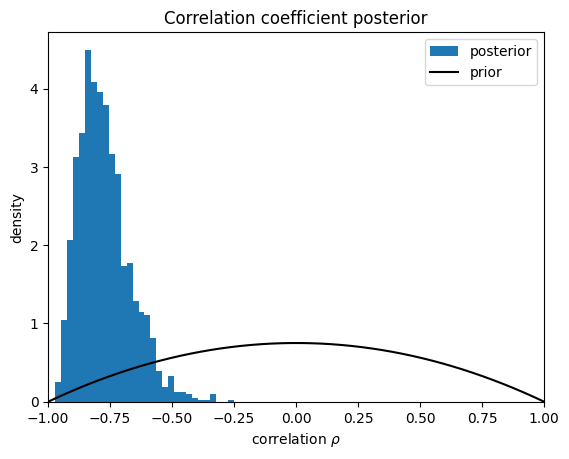

In [54]:
# plot posterior samples
R = m14_1.get_samples()["R"]
R = torch.einsum("ijk,ilk->ijl", R, R)

rho = R[:,0,1]

print("posterior rho:", rho.mean().item(), "+/-", rho.std().item())
plt.hist(rho, bins=30, density=True, label="posterior")
# plot prior density
rho = torch.linspace(-0.999, .999, 50)
R = torch.ones(len(rho), 2, 2).double()
R[:,0,1] = rho
R[:,1,0] = rho
L = torch.linalg.cholesky(R)
p = LKJCholesky(2, tt(2.)).log_prob(L).exp()
plt.plot(rho, p, color="black", label="prior")
# labels
plt.xlabel(r"correlation $\rho$")
plt.ylabel("density")
plt.title("Correlation coefficient posterior")
plt.xlim(left=-1, right=1)
plt.legend()
plt.show()

Let's visualize the shrinkage that we get from using our multilevel model as opposed to one that doesn't pool observations. We'll plot the distribution of intercepts/slopes, and morning/afternoon waits, comparing the observed values and the mean posterior samples.

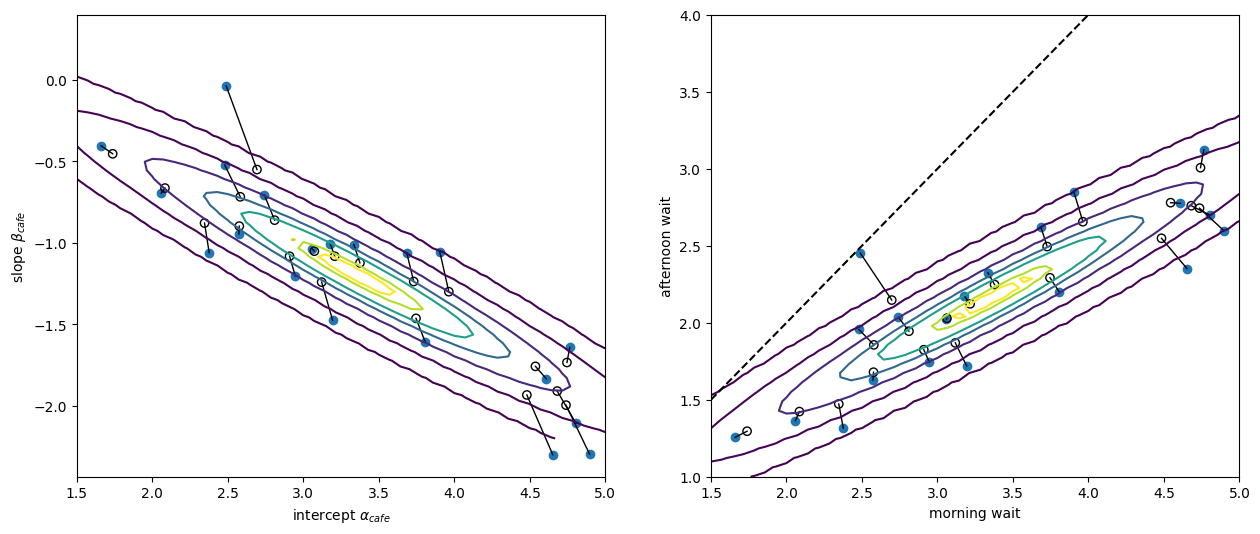

In [55]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

# plot intercepts vs slopes
plt.sca(axes[0])
# compute unpooled estimates from data
means = df.groupby(["cafe", "afternoon"])["wait"].mean()
a1 = means[:,0].values
b1 = means[:,1].values - a1
# extract posterior means of partially pooled estimates
s = m14_1.get_samples()
a2 = s["cafe"][:,:,0].mean(dim=0).numpy()
b2 = s["cafe"][:,:,1].mean(dim=0).numpy()
# plot and connect with lines
for i in range(len(a1)):
    plt.scatter(a1[i], b1[i], color="C0")
    plt.scatter(a2[i], b2[i], facecolor="none", edgecolor="black")
    plt.plot([a1[i], a2[i]], [b1[i], b2[i]], color="black", linewidth=1)
# plot pooled density contours for the pooled population
S = np.cov([a2, b2])
mu = np.mean([a2, b2], axis=1)[:,None,None]
XY = np.stack(np.meshgrid(np.linspace(1.5, 5), np.linspace(-2.2, 0.4)))
Z = np.exp(-np.einsum("abc,ad,dbc->bc", XY-mu, np.linalg.inv(S), XY-mu))
plt.contour(XY[0], XY[1], Z, levels=[1e-4, 1e-2, 1e-1, 0.3, 0.5, 0.8, 0.9])
plt.xlabel(r"intercept $\alpha_{cafe}$")
plt.ylabel(r"slope $\beta_{cafe}$")

# plot morning vs afternoon wait times
plt.sca(axes[1])
# compute unpooled estimates from data
means = df.groupby(["cafe", "afternoon"])["wait"].mean()
a1 = means[:,0].values
b1 = means[:,1].values
# extract posterior means of partially pooled estimates
W = Predictive(model_m14_1, m14_1.get_samples(), return_sites=("W",))(data)["W"].mean(dim=0)
_df = df.copy()
_df["post_wait"] = W
means = _df.groupby(["cafe", "afternoon"])["post_wait"].mean()
a2 = means[:,0].values
b2 = means[:,1].values
# plot and connect with lines
for i in range(len(a1)):
    plt.scatter(a1[i], b1[i], color="C0")
    plt.scatter(a2[i], b2[i], facecolor="none", edgecolor="black")
    plt.plot([a1[i], a2[i]], [b1[i], b2[i]], color="black", linewidth=1)
# plot pooled density contours for the pooled population
S = np.cov([a2, b2])
mu = np.mean([a2, b2], axis=1)[:,None,None]
XY = np.stack(np.meshgrid(np.linspace(1.5, 5), np.linspace(1, 4)))
Z = np.exp(-np.einsum("abc,ad,dbc->bc", XY-mu, np.linalg.inv(S), XY-mu))
plt.contour(XY[0], XY[1], Z, levels=[1e-4, 1e-2, 1e-1, 0.3, 0.5, 0.8, 0.9])
x, y = XY[0,0,:][[0, -1]], XY[1,:,0][[0, -1]]
x = np.linspace(max(x[0], y[0]), min(x[1], y[1]))
plt.plot(x, x, color="black", linestyle="--")
plt.xlabel("morning wait")
plt.ylabel("afternoon wait")

plt.show()

## Code 14.18 - 14.22
The previous section showed how to incorporate pooled correlations across two different types of variables (intercepts/slopes) within the same type of category (cafes). But is it possible to pool more than one type of variable, or across categories, while including correlations? Yes! We'll examine this in the context of the chimpanzee dataset.

In [56]:
chimp_df = pd.read_csv("data/chimpanzees.csv", sep=";")
chimp_df["treatment"] = chimp_df["prosoc_left"] + 2*chimp_df["condition"]

data = {
    "num_treatments": chimp_df["treatment"].nunique(),
    "num_blocks": chimp_df["block"].nunique(),
    "num_actors": chimp_df["actor"].nunique(),
    "L": tt(chimp_df["pulled_left"].values).double(),
    "treatment": tt(chimp_df["treatment"].values).long(),
    "actor": tt(chimp_df["actor"].values-1).long(),
    "block": tt(chimp_df["block"].values-1).long(),
}
chimp_df.sample(5)

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
474,7,2.0,1,2,14,1,1,1,3
266,4,6.0,1,3,30,1,0,0,3
130,2,5.0,1,4,44,0,0,1,2
372,6,NaN,0,3,26,0,0,1,0
478,7,4.0,1,2,22,1,1,1,3


Our model will consist of a sum of linear factors where we now take into account the interaction between actor/treatment and block/treatment:

$$\begin{align*}
L_i &\sim \text{Bernoulli}(p_i) \\
p_i &= \text{sigmoid}\left( \gamma_\text{TID[i]} + \alpha_\text{ACTOR[i],TID[i]} + \beta_\text{BLOCK[i],TID[i]} \right)
\end{align*}$$
This model contains an average intercept for each treatment $\gamma_\text{TID[i]}$, an effect for each actor in each treatment $\alpha_\text{ACTOR[i],TID[i]}$, and an effect for each block in each treatment $\beta_\text{BLOCK[i],TID[i]}$. This yields a total of $4+7\times 4 + 6\times 4=56$ parameters.

The next part of the model are the adaptive priors. Since there are two cluster types, there are two multivariate Gaussian priors, which are 4-dimensional, because there are 4 treatments.

$$\begin{align*}
\alpha_{j} &\sim \text{Normal}(0, \boldsymbol{S}_\text{ACTOR}) \\
\beta_{j} &\sim \text{Normal}(0, \boldsymbol{S}_\text{BLOCK}) 
\end{align*}$$

In [57]:
def model_m14_2(data, training=False):
    nT, nB, nA = [data[k] for k in ("num_treatments", "num_blocks", "num_actors")]
    # fixed priors
    σa = pyro.sample("σa", Exponential(1.))
    σb = pyro.sample("σb",Exponential(1.))
    Ra = pyro.sample("Ra", LKJCholesky(nT, tt(2.)))
    Rb = pyro.sample("Rb", LKJCholesky(nT, tt(2.)))

    Sa = torch.mm(torch.diag(torch.cat(nT*[σa.reshape(1)])), Ra)
    Sb = torch.mm(torch.diag(torch.cat(nT*[σa.reshape(1)])), Rb)
    
    # adaptive priors
    α = pyro.sample("α", MultivariateNormal(torch.zeros([nT]), scale_tril=Sa).expand([nA]))
    β = pyro.sample("β", MultivariateNormal(torch.zeros([nT]), scale_tril=Sb).expand([nB]))
    γ = pyro.sample("γ", Normal(0., 1.).expand([nT]))
    T, A, B = [data[k] for k in ("treatment", "actor", "block")]

    p = torch.sigmoid(γ[T] + α[A,T] + β[B,T])
    if training:
        pyro.sample("L", Bernoulli(p), obs=data["L"])
    else:
        return pyro.sample("L", Bernoulli(p))

In [58]:
m14_2 = train_nuts(model_m14_2, data, 1000, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Warmup:   0%|          | 0/3000 [00:00, ?it/s]/tmp/ipykernel_18842/1581628107.py:5: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  Ra = pyro.sample("Ra", LKJCholesky(nT, tt(2.)))
/tmp/ipykernel_18842/1581628107.py:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  Rb = pyro.sample("Rb", LKJCholesky(nT, tt(2.)))
Sample: 100%|██████████| 3000/3000 [01:08, 43.78it/s, step size=2.12e-01, acc. prob=0.842]


In [59]:
x = m14_2.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Ra[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
   Ra[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[0,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[0,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[1,0]      0.41      0.28      0.44     -0.02      0.87       nan      1.00
   Ra[1,1]      0.86      0.14      0.90      0.67      1.00       nan      1.00
   Ra[1,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[1,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[2,0]      0.60      0.19      0.63      0.29      0.89       nan      1.00
   Ra[2,1]      0.22      0.28      0.25     -0.25      0.67       nan      1.00
   Ra[2,2]      0.66      0.16      0.67      0.43      0.95       nan      1.00
   Ra[2,3]      0.00      0

We can also use reparametrization of the normal distributions here to improve sampling efficiency. We can turn any normal sample from the centered parametrization

$$
x \sim \text{Normal}(\mu, \Sigma)
$$

into a non-centered parametrization of the form

$$
z \sim \text{Normal}(0, I) \\
x = \mu + Lz
$$

where $L$ is the Cholesky factor of the covariance matrix: $\Sigma = LL^T$

In [60]:
# https://stackoverflow.com/a/55894780/1124142
def model_m14_3(data, training=False):
    nT, nB, nA = [data[k] for k in ("num_treatments", "num_blocks", "num_actors")]
    σa = pyro.sample("σa", Exponential(1.))
    σb = pyro.sample("σb",Exponential(1.))
    Ra = pyro.sample("Ra", LKJCholesky(nT, tt(2.)))
    Rb = pyro.sample("Rb", LKJCholesky(nT, tt(2.)))
    Sa = torch.mm(torch.diag(torch.cat(nT*[σa.reshape(1)])), Ra)
    Sb = torch.mm(torch.diag(torch.cat(nT*[σa.reshape(1)])), Rb)
    zero = torch.zeros([nT])
    I = torch.eye(nT)
    α = torch.einsum("ij,kj->ki", Sa, pyro.sample("zα", MultivariateNormal(zero, I).expand([nA])))
    β = torch.einsum("ij,kj->ki", Sb, pyro.sample("zβ", MultivariateNormal(zero, I).expand([nB])))
    γ = pyro.sample("γ", Normal(0., 1.).expand([nT]))
    T, A, B = [data[k] for k in ("treatment", "actor", "block")]
    p = torch.sigmoid(γ[T] + α[A,T] + β[B,T])
    with pyro.plate("obs", dim=-1):
        if training:
            pyro.sample("L", Bernoulli(p), obs=data["L"])
        else:
            return pyro.sample("L", Bernoulli(p))

In [61]:
m14_3 = train_nuts(model_m14_3, data, 1000, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Warmup:   0%|          | 0/3000 [00:00, ?it/s]/tmp/ipykernel_18842/3203956820.py:5: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  Ra = pyro.sample("Ra", LKJCholesky(nT, tt(2.)))
/tmp/ipykernel_18842/3203956820.py:6: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  Rb = pyro.sample("Rb", LKJCholesky(nT, tt(2.)))
Sample: 100%|██████████| 3000/3000 [01:07, 44.65it/s, step size=2.43e-01, acc. prob=0.845]


In [62]:
m14_3.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Ra[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
   Ra[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[0,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[0,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[1,0]      0.41      0.28      0.44     -0.06      0.82       nan      1.00
   Ra[1,1]      0.86      0.14      0.90      0.67      1.00       nan      1.00
   Ra[1,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[1,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
   Ra[2,0]      0.59      0.20      0.61      0.29      0.93       nan      1.00
   Ra[2,1]      0.23      0.28      0.24     -0.19      0.70       nan      1.00
   Ra[2,2]      0.67      0.17      0.69      0.41      0.96       nan      1.00
   Ra[2,3]      0.00      0

If we compare the centered and non-centered models, the improvement doesn't seem as great as the textbook makes it seem. The time to complete sampling is slightly lower for the non-centered model, but it is only a bit more efficient when looking at the effective number of samples:

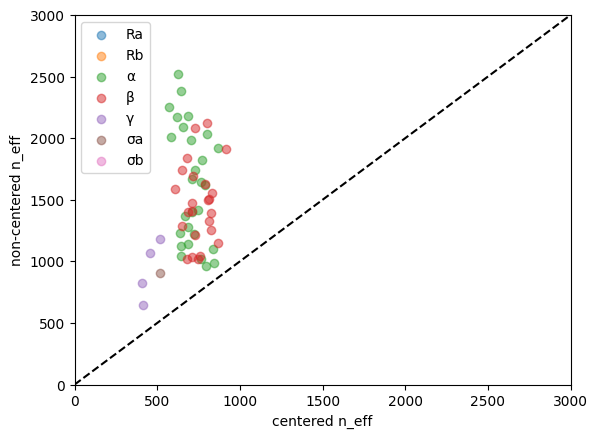

In [63]:
d1 = m14_2.diagnostics()
d2 = m14_3.diagnostics()
ignore = ("divergences", "acceptance rate")
for k1, k2 in zip(d1, d2):
    if k1 in ignore or k2 in ignore:
        continue
    plt.scatter(d1[k1]["n_eff"].reshape(-1), d2[k2]["n_eff"].reshape(-1), alpha=0.5, label=k1)
plt.axline((0, 0), slope=1, linestyle='--', color='k')
plt.legend()
plt.xlabel("centered n_eff")
plt.ylabel("non-centered n_eff")
plt.xlim(0,3000)
plt.ylim(0,3000)
plt.show()

We can also compare the WAIC of the two models. We can see that even though there are >70 parameters (56 original parameters plus the free parameters in the correlation matrices) the number of effective parameters is closer to 30.

In [64]:
def get_log_prob(mcmc, data, site_names):
    samples = mcmc.get_samples()
    model = mcmc.kernel.model
    # get number of samples
    N = [v.shape[0] for v in samples.values()]
    assert [n == N[0] for n in N]
    N = N[0]
    if isinstance(site_names, str):
        site_names = [site_names]
    # iterate over samples
    log_prob = torch.zeros(N, len(data[site_names[0]]))
    for i in range(N):
        # condition on samples and get trace
        s = {k: v[i] for k, v in samples.items()}
        for nm in site_names:
            s[nm] = data[nm]
        tr = poutine.trace(poutine.condition(model, data=s)).get_trace(data)
        # get pointwise log probability
        for nm in site_names:
            node = tr.nodes[nm]
            log_prob[i] += node["fn"].log_prob(node["value"])
    return log_prob

In [65]:
az_data = dict()
for nm, model in (("m14.2", m14_2), ("m14.3", m14_3)):
    az_data[nm] = az.from_pyro(model, log_likelihood=False)
    ll = get_log_prob(model, data, "L")[None,...].numpy()
    ll = az.convert_to_dataset(ll, group="log_likelihood")
    az_data[nm].log_likelihood = ll
    az_data[nm]._groups.append("log_likelihood")

In [66]:
az.compare(az_data, ic="waic", scale="deviance")

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m14.2,0,549.703801,32.025810,0.000000,1.000000e+00,19.568320,0.000000,True,deviance
m14.3,1,550.665852,32.465343,0.962051,2.109424e-15,19.544374,0.421275,True,deviance


Let's take one final look at the posterior predictions against the average for each actor/treatment combo.

In [67]:
# get actual proportions
pl = chimp_df.groupby(["actor", "treatment"])["pulled_left"].mean().reset_index()
pl["actor"] -= 1
block = 4
# get posterior predictive samples
_data = {
    "actor": tt(pl["actor"].values).long(),
    "treatment": tt(pl["treatment"].values).long(),
    "block": block*torch.ones(len(pl)).long()
}
pred = Predictive(model_m14_2, m14_2.get_samples(), return_sites=list("αβγ"))(data)
# calculate posterior means/CI's
T, A, B = [_data[k] for k in ("treatment", "actor", "block")]
p = torch.sigmoid(pred["γ"][:,T] + pred["α"][:,A,T] + pred["β"][:,B,T])
p_mu = p.mean(dim=0)
p_ci = hpdi(p, prob=0.89, dim=0).T

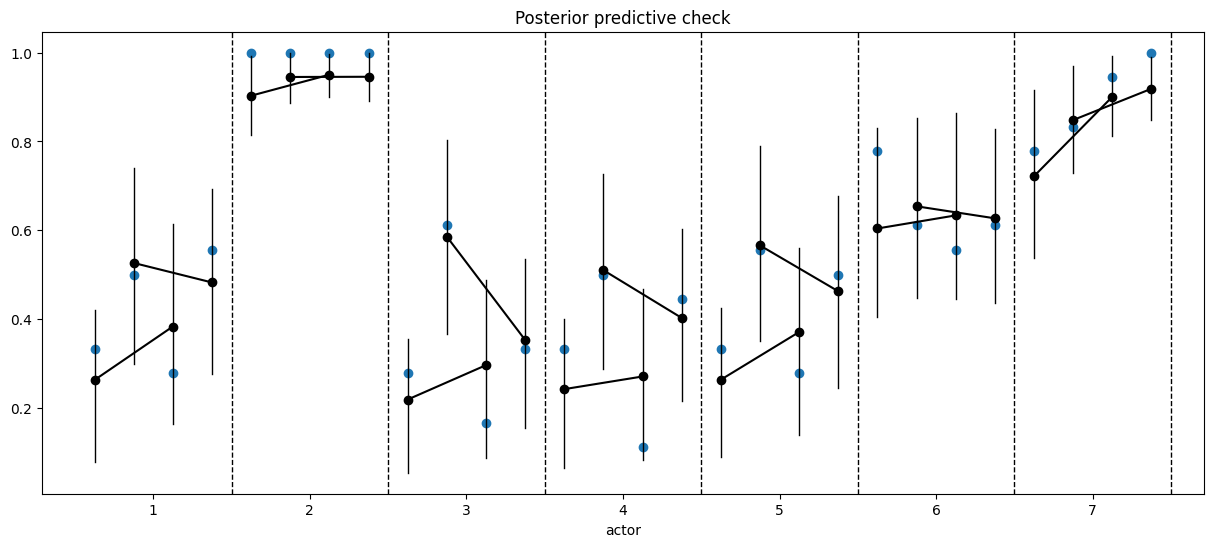

In [68]:
# make plot
plt.figure(figsize=(15, 6))
# plot data
plt.scatter(range(len(pl)), pl["pulled_left"], color="C0")
# plot posterior means
plt.scatter(range(len(pl)), p_mu, color="black")
# plot posterior CI's
for i in range(len(p_ci)):
    plt.plot(2*[i], p_ci[i], color="black", linewidth=1)
# connect the posterior means
for a in range(chimp_df["actor"].nunique()):
    for i in (0, 1):
        x = [4*a+i, 4*a+i+2]
        y = p_mu[[*x]]
        plt.plot(x, y, color="black")
    plt.axvline(4*(a+1)-0.5, color="black", linewidth=1, linestyle="--")
plt.xlabel("actor")
ticks = [4*(a+1)-2.5 for a in range(chimp_df["actor"].nunique())]
labels = [i+1 for i in range(chimp_df["actor"].nunique())]
plt.xticks(ticks, labels)
plt.title("Posterior predictive check")
plt.show()